## Speech Recognition using Keras
---

The model used in this notebook comes from https://www.kaggle.com/alexozerin/end-to-end-baseline-tf-estimator-lb-0-72

In [1]:
import os
import re
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

First let's look at the data that we have. It turns out that we have two text files that contains the file name for validation and test set, and a directory `'audio'` that contains the wav files.

In [2]:
ls ../input/train

LICENSE  README.md  audio/  testing_list.txt  validation_list.txt


Here we can see all the labels we have in our dataset. And for now let's only deal with 10 labels:

**yes no up down left right on off stop go**

In [3]:
labels = []
for i in glob('../input/train/audio/*/*.wav'):
    labels += [i.split('/')[-2]]
labels = np.unique(np.array(labels), return_counts=True)

d = {}
for i in range(len(labels[0])):
    d[labels[0][i]] = labels[1][i]
print(d)

{'_background_noise_': 6, 'bed': 1713, 'bird': 1731, 'cat': 1733, 'dog': 1746, 'down': 2359, 'eight': 2352, 'five': 2357, 'four': 2372, 'go': 2372, 'happy': 1742, 'house': 1750, 'left': 2353, 'marvin': 1746, 'nine': 2364, 'no': 2375, 'off': 2357, 'on': 2367, 'one': 2370, 'right': 2367, 'seven': 2377, 'sheila': 1734, 'six': 2369, 'stop': 2380, 'three': 2356, 'tree': 1733, 'two': 2373, 'up': 2375, 'wow': 1745, 'yes': 2377, 'zero': 2376}


In [4]:
POSSIBLE_LABELS = d.keys()
#POSSIBLE_LABELS = 'yes no up down left right on off stop go unknown silence'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
print(id2name)

{0: '_background_noise_', 1: 'bed', 2: 'bird', 3: 'cat', 4: 'dog', 5: 'down', 6: 'eight', 7: 'five', 8: 'four', 9: 'go', 10: 'happy', 11: 'house', 12: 'left', 13: 'marvin', 14: 'nine', 15: 'no', 16: 'off', 17: 'on', 18: 'one', 19: 'right', 20: 'seven', 21: 'sheila', 22: 'six', 23: 'stop', 24: 'three', 25: 'tree', 26: 'two', 27: 'up', 28: 'wow', 29: 'yes', 30: 'zero'}


Let's load our data and their file names into a dataframe.

In [5]:
def load_data(data_dir):
    """ Return three dataframes for train,  validation, and test data
    """
    # Just a simple regexp for paths with three groups:
    # prefix, label, user_id
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    all_files = glob(os.path.join(data_dir, 'train/audio/*/*wav'))

    validation_files = np.loadtxt(os.path.join(data_dir, 'train/validation_list.txt'), dtype='str')
    print("Example in 'validation_list.txt': ", validation_files[0])
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))
            
    testing_files = np.loadtxt(os.path.join(data_dir, 'train/testing_list.txt'), dtype='str')
    testset = set()
    for entry in testing_files:
        r = re.match(pattern, entry)
        if r:
            testset.add(r.group(3))

    possible = set(POSSIBLE_LABELS)
    train, val, test = [], [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            #if label == '_background_noise_':
            #    label = 'silence'
            #elif label not in possible:
            #    label = 'unknown'

            label_id = name2id[label]

            sample = (label, label_id, uid, entry)
            if uid in valset:
                val.append(sample)
            elif uid in testset:
                test.append(sample)
            else:
                train.append(sample)

    print('There are {} train, {} val, and {} test samples'.format(len(train), len(val), len(test)))
    
    columns_list = ['label', 'label_id', 'user_id', 'wav_file']
    
    train_df = pd.DataFrame(train, columns = columns_list)
    valid_df = pd.DataFrame(val, columns = columns_list)
    test_df = pd.DataFrame(test, columns = columns_list)
    
    return train_df, valid_df, test_df

In [6]:
train_df, valid_df, test_df = load_data('../input/')

Example in 'validation_list.txt':  bed/026290a7_nohash_0.wav
There are 51094 train, 6798 val, and 6835 test samples


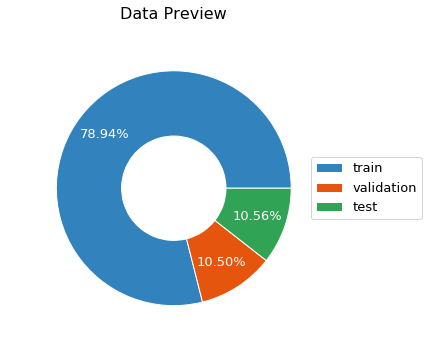

In [7]:
fig = plt.figure(figsize=(6, 6))
vals = np.array([train_df.shape[0], valid_df.shape[0], test_df.shape[0]])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
wedges, a, a = plt.pie(vals, radius=0.9, autopct="%.2f%%", colors=outer_colors, pctdistance=0.75, 
       wedgeprops=dict(width=0.5, edgecolor='w'), textprops={'fontsize': 13, 'color': 'w'})
plt.legend(wedges, ['train', 'validation', 'test'], fontsize=13, loc="center left", bbox_to_anchor=(0.9, 0, 0, 1))

plt.title('Data Preview', fontsize=16)
plt.show()

In [8]:
train_df.head()

,label,label_id,user_id,wav_file
0,yes,29,baeac2ba,../input/train/audio/yes/baeac2ba_nohash_0.wav
1,yes,29,ba59cab3,../input/train/audio/yes/ba59cab3_nohash_0.wav
2,yes,29,8ff44869,../input/train/audio/yes/8ff44869_nohash_0.wav
3,yes,29,4abb2400,../input/train/audio/yes/4abb2400_nohash_0.wav
4,yes,29,df1d5024,../input/train/audio/yes/df1d5024_nohash_1.wav


In [9]:
train_df.label.value_counts()

one                   1892
stop                  1885
nine                  1875
seven                 1875
two                   1873
zero                  1866
on                    1864
six                   1863
go                    1861
yes                   1860
no                    1853
right                 1852
eight                 1852
five                  1844
up                    1843
down                  1842
three                 1841
off                   1839
four                  1839
left                  1839
house                 1427
marvin                1424
wow                   1414
bird                  1411
cat                   1399
dog                   1396
tree                  1374
happy                 1373
sheila                1372
bed                   1340
_background_noise_       6
Name: label, dtype: int64

In [10]:
silence_files = train_df[train_df.label == '_background_noise_']
train_df      = train_df[train_df.label != '_background_noise_']
POSSIBLE_LABELS = train_df.label.unique().tolist()

Let's start by reading the wav files into numpy array using `scipy.io.wavfile`.

In [11]:
from scipy.io import wavfile

def read_wav_file(fname):
    _, wav = wavfile.read(fname)
    wav = wav.astype(np.float32) / np.iinfo(np.int16).max
    return wav

In [12]:
silence_data = np.concatenate([read_wav_file(x) for x in silence_files.wav_file.values])

/opt/conda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [13]:
from scipy.signal import stft

def process_wav_file(fname):
    wav = read_wav_file(fname)
    
    L = 16000  # 1 sec
    
    if len(wav) > L:
        i = np.random.randint(0, len(wav) - L)
        wav = wav[i:(i+L)]
    elif len(wav) < L:
        rem_len = L - len(wav)
        i = np.random.randint(0, len(silence_data) - rem_len)
        silence_part = silence_data[i:(i+L)]
        j = np.random.randint(0, rem_len)
        silence_part_left  = silence_part[0:j]
        silence_part_right = silence_part[j:rem_len]
        wav = np.concatenate([silence_part_left, wav, silence_part_right])
    
    specgram = stft(wav, 16000, nperseg = 400, noverlap = 240, nfft = 512, padded = False, boundary = None)
    phase = np.angle(specgram[2]) / np.pi
    amp = np.log1p(np.abs(specgram[2]))
    
    return np.stack([phase, amp], axis = 2)

Let's look at one example of the wav file, and see how its spectrum looks like.

Codes comes from https://www.kaggle.com/davids1992/speech-representation-and-data-exploration

In [14]:
from scipy import signal

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

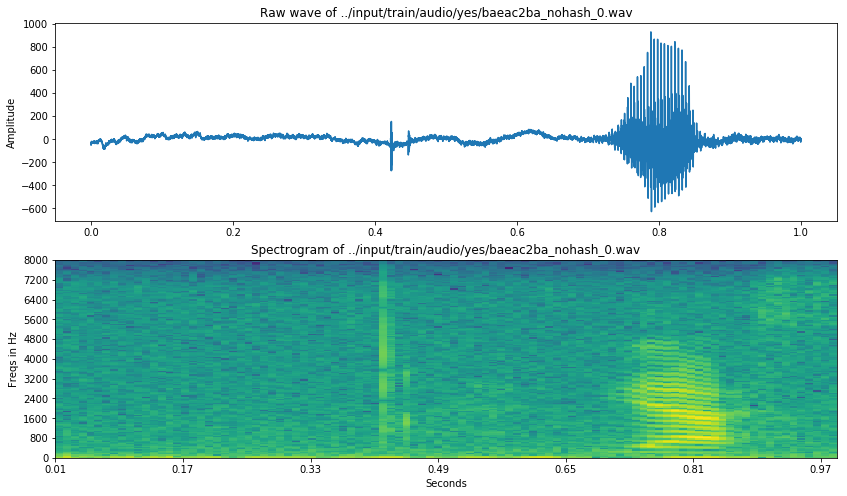

In [15]:
sample_rate, samples = wavfile.read(train_df.wav_file[1])
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + train_df.wav_file[0])
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + train_df.wav_file[0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')
plt.show()

Here is the **Mel power spectrogram** and **MFCC** graph. We actually don't use them in our model, but just keep in mind these are also good input types for audio problems.

In [16]:
import librosa

sample_rate, samples = wavfile.read(train_df.wav_file[0])
S = librosa.feature.melspectrogram(samples.astype(np.float32), sr=sample_rate, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

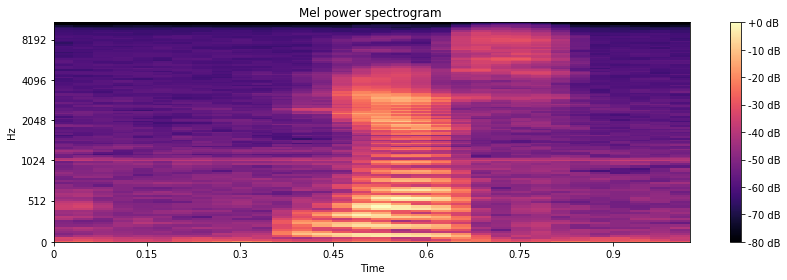

In [17]:
import librosa.display

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

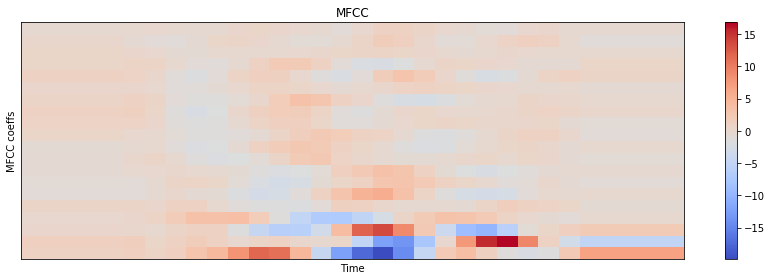

In [18]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=20)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

We can also listen to this audio using `Ipython.display`.

In [19]:
train_df.wav_file[0]

'../input/train/audio/yes/baeac2ba_nohash_0.wav'

In [20]:
import IPython.display as ipd

sample_rates = []
samples = []
for i in range(10):
    sample_rate, sample = wavfile.read(train_df.wav_file[i])
    sample_rates += [sample_rate]
    samples += [sample]

In [21]:
ipd.Audio(samples[0], rate=sample_rates[0])

---

## Building models using Keras

In [22]:
import random
import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, Activation, BatchNormalization
from tensorflow.python.keras.layers import GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout, CuDNNGRU, ELU
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Build data loaders for the model

In [23]:
def train_generator(train_batch_size, sample_number):
    while True:
        replace = False
        if sample_number > 1340:
            replace = True
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = sample_number, replace=replace))
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(process_wav_file(this_train.wav_file.values[i]))
                y_batch.append(this_train.label_id.values[i])
            x_batch = np.array(x_batch)
            #y_batch = to_categorical(y_batch, num_classes=len(POSSIBLE_LABELS))
            y_batch = label_binarize(y_batch, classes=range(len(POSSIBLE_LABELS)))
            yield x_batch, y_batch

In [24]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(process_wav_file(valid_df.wav_file.values[i]))
                y_batch.append(valid_df.label_id.values[i])
            x_batch = np.array(x_batch)
            #y_batch = to_categorical(y_batch, num_classes=len(POSSIBLE_LABELS))
            y_batch = label_binarize(y_batch, classes=range(len(POSSIBLE_LABELS)))
            yield x_batch, y_batch

Model structure:

In [25]:
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dense, Dropout, Reshape, Permute
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.layers import ELU
from keras.layers import CuDNNGRU
from keras.optimizers import SGD

input_shape = (257, 98, 2)
channel_axis = 3
freq_axis = 2
time_axis = 1

melgram_input = Input(shape=input_shape)
#x = ZeroPadding2D(padding=(0, 37))(melgram_input)
x = BatchNormalization(axis=freq_axis, name='bn_0_freq')(melgram_input)

# Conv block 1
x_1 = Conv2D(64, (3, 3), name="conv1", padding="same")(x)
x_1 = BatchNormalization(axis=channel_axis, name="bn1")(x_1)
x_1 = ELU()(x_1)
x_1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')(x_1)
x_1 = Dropout(0.1, name='dropout1')(x_1)

# Conv block 2
x_2 = Conv2D(128, (3, 3), name="conv2", padding="same")(x_1)
x_2 = BatchNormalization(axis=channel_axis, name="bn2")(x_2)
x_2 = ELU()(x_2)
x_2 = MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool2')(x_2)
x_2 = Dropout(0.1, name='dropout2')(x_2)

# Conv block 3
x_3 = Conv2D(128, (3, 3), name="conv3", padding="same")(x_2)
x_3 = BatchNormalization(axis=channel_axis, name="bn3")(x_3)
x_3 = ELU()(x_3)
x_3 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool3')(x_3)
x_3 = Dropout(0.1, name='dropout3')(x_3)

# Conv block 4
x_4 = Conv2D(128, (3, 3), name="conv4", padding="same")(x_3)
x_4 = BatchNormalization(axis=channel_axis, name="bn4")(x_4)
x_4 = ELU()(x_4)
x_4 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool4')(x_4)
x_4 = Dropout(0.1, name='dropout4')(x_4)

# reshaping
x = Reshape((2, 128))(x_4)

# GRU block 1, 2, output
x_gru = CuDNNGRU(32, return_sequences=True, name='gru1')(x)
x_gru = CuDNNGRU(32, return_sequences=False, name='gru2')(x_gru)
x_gru = Dropout(0.3)(x_gru)
output = Dense(11, activation='sigmoid', name='output')(x_gru)

model = Model(inputs = melgram_input, outputs = output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 257, 98, 2)        0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 257, 98, 2)        392       
_________________________________________________________________
conv1 (Conv2D)               (None, 257, 98, 64)       1216      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 257, 98, 64)       256       
_________________________________________________________________
elu_1 (ELU)                  (None, 257, 98, 64)       0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 49, 64)       0         
_________________________________________________________________
dropout1 (Dropout)           (None, 128, 49, 64)       0         
__________

In [26]:
x_in = Input(shape = (257,98,2)) # Input layer
x = BatchNormalization()(x_in)
for i in range(4): # Four convolutional layer modules.
    x = Conv2D(16*(2 ** i), (3,3))(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.1)(x)
x = Conv2D(128, (1,1))(x)
x_branch_1 = AveragePooling2D()(x)
x_branch_2 = MaxPooling2D()(x)
x = concatenate([x_branch_1, x_branch_2]) # Take use of both pooling by concate
x = Reshape((7, 512))(x)
x_gru = CuDNNGRU(32, return_sequences=True)(x)
x_gru = CuDNNGRU(32, return_sequences=False)(x_gru)
x_gru = Dropout(0.3)(x_gru)
x = Dense(256, activation = 'relu')(x_gru) # Linear layer
x = Dropout(0.5)(x)
x = Dense(len(POSSIBLE_LABELS), activation = 'softmax')(x) # Output layer

model = Model(inputs = x_in, outputs = x)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

AttributeError: 'tuple' object has no attribute 'layer'

In [27]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [EarlyStopping(monitor='val_acc', patience=10, verbose=1, min_delta=0.01, mode='max'),
             ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=3, verbose=1, epsilon=0.01, mode='max'),
             ModelCheckpoint(monitor='val_acc', filepath='starter.hdf5', verbose=1, save_best_only=True, save_weights_only=True, mode='max')]

In [28]:
history = model.fit_generator(generator=train_generator(256), steps_per_epoch=151, epochs=50, verbose=1, callbacks=callbacks,
                              validation_data=valid_generator(256), validation_steps=151)

TypeError: train_generator() missing 1 required positional argument: 'sample_number'

In [29]:
batch_size=256
sample_size=1700 # upsample/downsample all categories to the same size
history = model.fit_generator(generator=train_generator(batch_size, sample_size),
                              steps_per_epoch=sample_size*len(POSSIBLE_LABELS)//batch_size, epochs=100, verbose=1, callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=sample_size*len(POSSIBLE_LABELS)//batch_size)

Epoch 1/100


ValueError: Error when checking target: expected output to have shape (11,) but got array with shape (30,)

In [30]:
model.load_weights('starter.hdf5')

OSError: Unable to open file (unable to open file: name = 'starter.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [31]:
X_test = []
for i in test_df.wav_file.values:
    X_test += [process_wav_file(i)]
X_test = np.array(X_test)

In [32]:
predictions = model.predict(X_test)

In [33]:
classes = np.argmax(predictions, axis=1)

In [34]:
classes

array([10, 10, 10, ..., 10, 10, 10])

---

## Results analysis

In [35]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from itertools import cycle
from scipy import interp

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid(axis='y')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=13)
plt.show()

NameError: name 'history' is not defined

<Figure size 720x432 with 0 Axes>

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.grid(axis='y')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=13)
plt.show()

NameError: name 'history' is not defined

<Figure size 720x432 with 0 Axes>

Test set accuracy:  2.63%


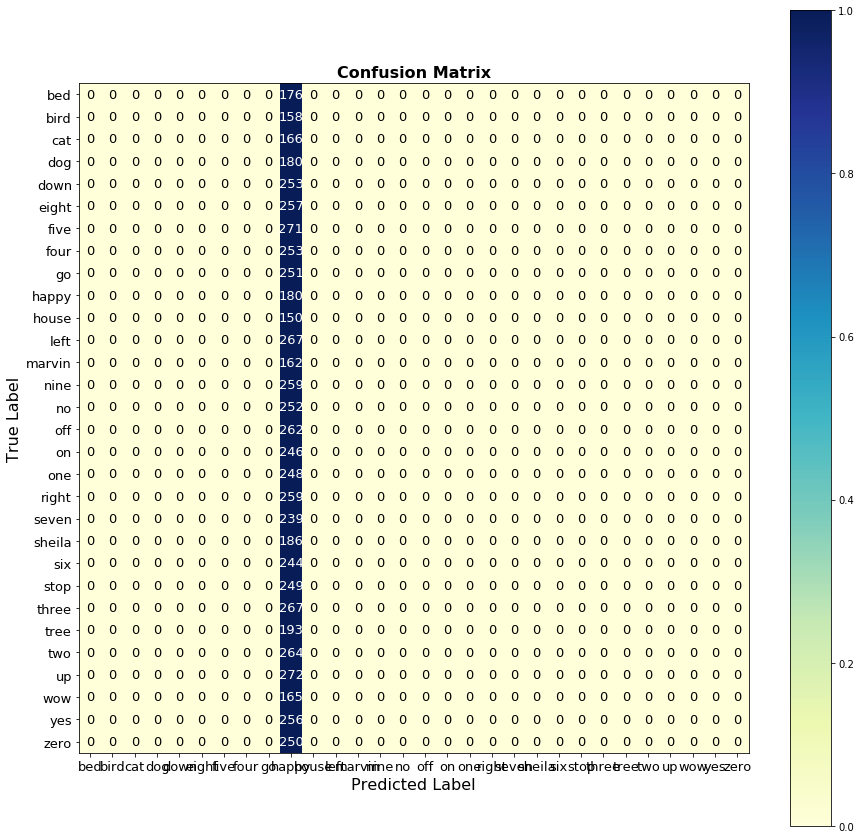

In [38]:
y_test_class = test_df.label_id.values
pred = model.predict(X_test)
cm = confusion_matrix(y_test_class, np.argmax(pred, axis=1))
print('Test set accuracy: ', str(round(np.sum(y_test_class == np.argmax(pred, axis=1))/test_df.shape[0], 4)*100)+'%')
num_classes = cm.shape[0]
count = np.unique(y_test_class, return_counts=True)[1].reshape(num_classes, 1)

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
im = ax.imshow(cm/count, cmap='YlGnBu')
im.set_clim(0, 1)
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
plt.yticks(range(num_classes), list(name2id.keys())[1:], fontsize=13)
plt.xticks(range(num_classes), list(name2id.keys())[1:], fontsize=13)
for i in range(num_classes):
    for j in range(num_classes):
        text = ax.text(i, j, cm[j][i], ha="center", va="center", color="w" if (cm/count)[j, i] > 0.5 else "black", fontsize=13)
ax.set_ylabel('True Label', fontsize=16)
ax.set_xlabel('Predicted Label', fontsize=16)
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [39]:
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_test_class, classes=range(num_classes))

fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# Compute macro-average ROC curve and AUC
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Average and compute AUC
mean_tpr /= num_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

# Plot all ROC curves
plt.figure(figsize=(10, 10))
    
for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], alpha=0.2,
                 label='ROC curve of class {0} (area = {1:0.4f})'
                 ''.format(id2name[i+1], roc_auc[i]))

plt.plot(fpr['micro'], tpr['micro'],
         label='micro-average ROC curve (area = {0:0.4f})'
         ''.format(roc_auc['micro']),
         color='orangered', linestyle=':', linewidth=3)

plt.plot(fpr['macro'], tpr['macro'],
         label='macro-average ROC curve (area = {0:0.4f})'
         ''.format(roc_auc['macro']),
         color='navy', linestyle=':', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=13)
plt.xticks(fontsize=13)
plt.title('ROC Curves', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc=4)
plt.show()

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


IndexError: index 11 is out of bounds for axis 1 with size 11